<a href="https://colab.research.google.com/github/jmhuer/Fall2021MusicResearch/blob/main/Fall2021MusicResearch/metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Usage Demo : 


In [6]:
# !rm -r python3_midi/
!sudo apt-get install libasound2-dev swig
# !pip3 install git+https://github.com/vishnubob/python-midi@feature/python3
!pip install git+https://github.com/vishnubob/python-midi@feature/python3
!pip install pretty_midi
!git clone https://github.com/gregwinther/mgeval


Cloning into 'mgeval'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 140 (delta 0), reused 2 (delta 0), pack-reused 137
Receiving objects: 100% (140/140), 138.41 KiB | 3.95 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [7]:
import midi
import glob
import numpy as np
import pretty_midi
import seaborn as sns
import matplotlib.pyplot as plt
from mgeval.mgeval import core, utils
from sklearn.model_selection import LeaveOneOut

In [8]:
# !unzip /content/1.001kwta.zip 
# !unzip /content/1.3kwta.zip

## Absolute measurement: statistic analysis


Assign dataset path

In [9]:
set1 = glob.glob('/content/1.001kwta/*.mid')

construct empty dictionary to fill in measurement across samples

In [10]:
num_samples = len(set1)
print(num_samples)

560


In [11]:
set1_eval = {'total_used_pitch':np.zeros((num_samples,1))}
metrics_list = list(set1_eval.keys())
for i in range(0, num_samples):
    feature = core.extract_feature(set1[i])
    set1_eval[metrics_list[0]][i] = getattr(core.metrics(), metrics_list[0])(feature)

repeat for second dataset

In [12]:
set2 = glob.glob('/content/1.3kwta/*.mid')
set2_eval = {'total_used_pitch':np.zeros((num_samples,1))}
for i in range(0, num_samples):
    feature = core.extract_feature(set2[i])
    set2_eval[metrics_list[0]][i] = getattr(core.metrics(), metrics_list[0])(feature)

statistic analysis: absolute measurement

In [18]:
print(len(metrics_list))

for i in range(0, len(metrics_list)):
    print(metrics_list[i] + ':')
    print('------------------------')
    print(' demo_set')
    print('  mean: ', np.mean(set1_eval[metrics_list[i]], axis=0))
    print('  std: ', np.std(set1_eval[metrics_list[i]], axis=0))

    print('------------------------')
    print(' demo_set')
    print('  mean: ', np.mean(set2_eval[metrics_list[i]], axis=0))
    print('  std: ', np.std(set2_eval[metrics_list[i]], axis=0))


1
total_used_pitch:
------------------------
 demo_set
  mean:  [27.35178571]
  std:  [6.58809779]
------------------------
 demo_set
  mean:  [30.30714286]
  std:  [6.71740429]


## Relative measurement: generalizes the result among features with various dimensions


the features are sum- marized to 
- the intra-set distances
- the difference of intra-set and inter-set distances.

exhaustive cross-validation for intra-set distances measurement

In [19]:
loo = LeaveOneOut()
loo.get_n_splits(np.arange(num_samples))
set1_intra = np.zeros((num_samples, len(metrics_list), num_samples-1))
set2_intra = np.zeros((num_samples, len(metrics_list), num_samples-1))
for i in range(len(metrics_list)):
    for train_index, test_index in loo.split(np.arange(num_samples)):
        # print(train_index)
        set1_intra[test_index[0]][i] = utils.c_dist(set1_eval[metrics_list[i]][test_index], set1_eval[metrics_list[i]][train_index])
        set2_intra[test_index[0]][i] = utils.c_dist(set2_eval[metrics_list[i]][test_index], set2_eval[metrics_list[i]][train_index])



exhaustive cross-validation for inter-set distances measurement

In [22]:
loo = LeaveOneOut()
loo.get_n_splits(np.arange(num_samples))
sets_inter = np.zeros((num_samples, len(metrics_list), num_samples))

for i in range(len(metrics_list)):
    for train_index, test_index in loo.split(np.arange(num_samples)):
        # print(test_index)
        sets_inter[test_index[0]][i] = utils.c_dist(set1_eval[metrics_list[i]][test_index], set2_eval[metrics_list[i]])


visualization of intra-set and inter-set distances

[[18.  9.  2. ...  1.  2. 10.]]


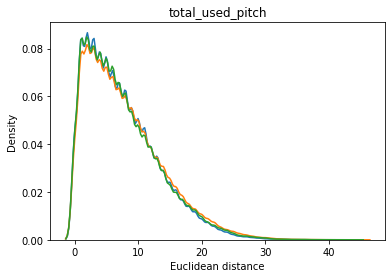

In [24]:
plot_set1_intra = np.transpose(set1_intra,(1, 0, 2)).reshape(len(metrics_list), -1)
print(plot_set1_intra)
plot_set2_intra = np.transpose(set2_intra,(1, 0, 2)).reshape(len(metrics_list), -1)
plot_sets_inter = np.transpose(sets_inter,(1, 0, 2)).reshape(len(metrics_list), -1)
for i in range(0,len(metrics_list)):
    sns.kdeplot(plot_set1_intra[i], label='1.0')
    sns.kdeplot(plot_sets_inter[i], label='inter')
    sns.kdeplot(plot_set2_intra[i], label='1.5')
    sns.kdeplot(backup[i], label='1.3')

    plt.title(metrics_list[i])
    plt.xlabel('Euclidean distance')
    plt.show()

the difference of intra-set and inter-set distances.

In [ ]:
for i in range(0, len(metrics_list)):
    print(metrics_list[i] + ':')
    print('------------------------')
    print(' demo_set1')
    print('  Kullback–Leibler divergence:',utils.kl_dist(plot_set1_intra[i], plot_sets_inter[i]))
    print(plot_set1_intra[i])
    print(plot_set2_intra[i])

    print('  Overlap area:', utils.overlap_area(plot_set1_intra[i], plot_sets_inter[i]))
    
    print(' demo_set2')
    print('  Kullback–Leibler divergence:',utils.kl_dist(plot_set2_intra[i], plot_sets_inter[i]))
    print('  Overlap area:', utils.overlap_area(plot_set2_intra[i], plot_sets_inter[i]))
    

In [ ]:
for i in range(0,len(metrics_list)):
